In [1]:
!pip install transformers==3

     |████████████████████████████████| 757kB 8.4MB/s 
     |████████████████████████████████| 3.0MB 47.5MB/s 
     |████████████████████████████████| 1.2MB 51.2MB/s 
     |████████████████████████████████| 901kB 46.4MB/s 


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from tqdm import tqdm


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 23
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!pip freeze > requirements.txt

In [4]:
data_train = pd.read_csv('/content/trac2_hin_train.csv')
data_train.head()

ID  ... Sub-task B
0     C4.131  ...       NGEN
1     C4.638  ...       NGEN
2    C38.598  ...       NGEN
3  C4.2101.1  ...       NGEN
4   C29.14.2  ...       NGEN

[5 rows x 4 columns]

In [5]:
data_test = pd.read_csv('/content/trac2_hin_dev.csv')

In [6]:
#data.drop(['ID','Sub-task B'], axis=1, inplace=True)
data_test.drop(['ID','Sub-task B'], axis=1, inplace=True)
data_train.drop(['ID','Sub-task B'], axis=1, inplace=True)


In [7]:
NAG_train = data_train[(data_train['Sub-task A']=='NAG')]
OAG_train= data_train[(data_train['Sub-task A']=='CAG')]
CAG_train= data_train[(data_train['Sub-task A']=='OAG')]

In [8]:
NAG_test = data_test[(data_test['Sub-task A']=='NAG')]
OAG_test= data_test[(data_test['Sub-task A']=='CAG')]
CAG_test = data_test[(data_test['Sub-task A']=='OAG')]

In [9]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_test["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_test["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_test["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

NAG_test.head()

Text  Sub-task A
1   Bhaiya shaadi mein zaroor aana movie ka plot j...           0
2   Section 375 hai kya??? .... Ye to batate kam s...           0
4              Maine itni kam dislike kbhi nhii dekhi           0
7   जिश देश मे super30 जैसी फ़िल्म फ्लॉप ओर कबीर सि...           0
11            Bhai movie review 5 se 7 mins Bano yaar           0

In [10]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_train["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_train["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_train["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1


In [11]:
data_test = pd.concat([NAG_test,
                  OAG_test,
                  CAG_test
                 ],axis=0)

data_test.reset_index(inplace=True)

In [12]:
data_train = pd.concat([NAG_train,
                  OAG_train,
                  CAG_train
                 ],axis=0)

data_train.reset_index(inplace=True)

In [13]:
data_test = data_test.rename(columns = {'Sub-task A': 'label'}, inplace = False)
data_train = data_train.rename(columns = {'Sub-task A': 'label'}, inplace = False)

In [14]:
train, test = train_test_split(data_test, test_size=0.1, random_state=23)
train, val = train_test_split(data_train, test_size=0.3,random_state=23)

In [15]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

In [16]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [17]:
sample_txt = 'you are a bad person , and you do not deserve good things'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: you are a bad person , and you do not deserve good things
   Tokens: ['you', 'are', 'a', 'bad', 'person', ',', 'and', 'you', 'do', 'not', 'des', '##er', '##ve', 'good', 'things']
Token IDs: [13028, 10301, 169, 15838, 15042, 117, 10111, 13028, 10149, 10472, 10139, 10165, 10612, 15198, 24682]


In [18]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [19]:
class_names = ['NAG', 'OAG', 'CAG']

In [20]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


dict_keys(['input_ids', 'attention_mask'])

In [21]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101, 13028, 10301,   169, 15838, 15042,   117, 10111, 13028, 10149,
        10472, 10139, 10165, 10612, 15198, 24682,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [22]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [23]:
class GPDataset(Dataset):
  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    comment = str(self.comments[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      comment,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'comment_text': comment,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [24]:
df_train, df_test = train_test_split(
  data_train,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [25]:
df_train.shape, df_val.shape, df_test.shape

((3585, 3), (199, 3), (200, 3))

In [26]:
MAX_LEN = 150

In [27]:
import logging
logging.basicConfig(level=logging.ERROR)

In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPDataset(
    comments=df.Text.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(data_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [29]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'targets'])

In [30]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [31]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [32]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [33]:
last_hidden_state.shape
torch.Size([1, 32, 768])

torch.Size([1, 32, 768])

In [34]:
bert_model.config.hidden_size

768

In [35]:
class Classifier(nn.Module):
  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [36]:
model = Classifier(len(class_names))
model = model.to(device)

In [37]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


In [38]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3923, 0.4023, 0.2054],
        [0.3973, 0.3413, 0.2614],
        [0.4320, 0.3580, 0.2100],
        [0.3671, 0.3919, 0.2410],
        [0.4262, 0.3526, 0.2213],
        [0.3467, 0.3948, 0.2584],
        [0.4090, 0.3079, 0.2832],
        [0.4652, 0.2788, 0.2560],
        [0.3508, 0.3921, 0.2571],
        [0.3703, 0.3722, 0.2575],
        [0.3735, 0.4025, 0.2240],
        [0.3576, 0.3689, 0.2734],
        [0.3159, 0.3809, 0.3032],
        [0.3379, 0.4164, 0.2458],
        [0.3344, 0.3461, 0.3195],
        [0.2929, 0.4741, 0.2330]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [39]:
EPOCHS = 30
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [40]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [41]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [42]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/30
----------
Train loss 0.9727551319864061 accuracy 0.5567642956764296
Val   loss 0.9416369749949529 accuracy 0.5678391959798995

Epoch 2/30
----------
Train loss 0.8461235060956743 accuracy 0.6050209205020921
Val   loss 0.8611283348156855 accuracy 0.5728643216080402

Epoch 3/30
----------
Train loss 0.792617347770267 accuracy 0.6468619246861925
Val   loss 0.8332139116067153 accuracy 0.628140703517588

Epoch 4/30
----------
Train loss 0.7174338573217391 accuracy 0.6847977684797768
Val   loss 0.8364071800158575 accuracy 0.6432160804020101

Epoch 5/30
----------
Train loss 0.6359373173448775 accuracy 0.7341701534170153
Val   loss 0.88047528725404 accuracy 0.6130653266331658

Epoch 6/30
----------
Train loss 0.5675053756766849 accuracy 0.7754532775453278
Val   loss 0.920964791224553 accuracy 0.6130653266331658

Epoch 7/30
----------
Train loss 0.5167706054780218 accuracy 0.801673640167364
Val   loss 0.9172535630372854 accuracy 0.6080402010050251

Epoch 8/30
----------
Train loss 

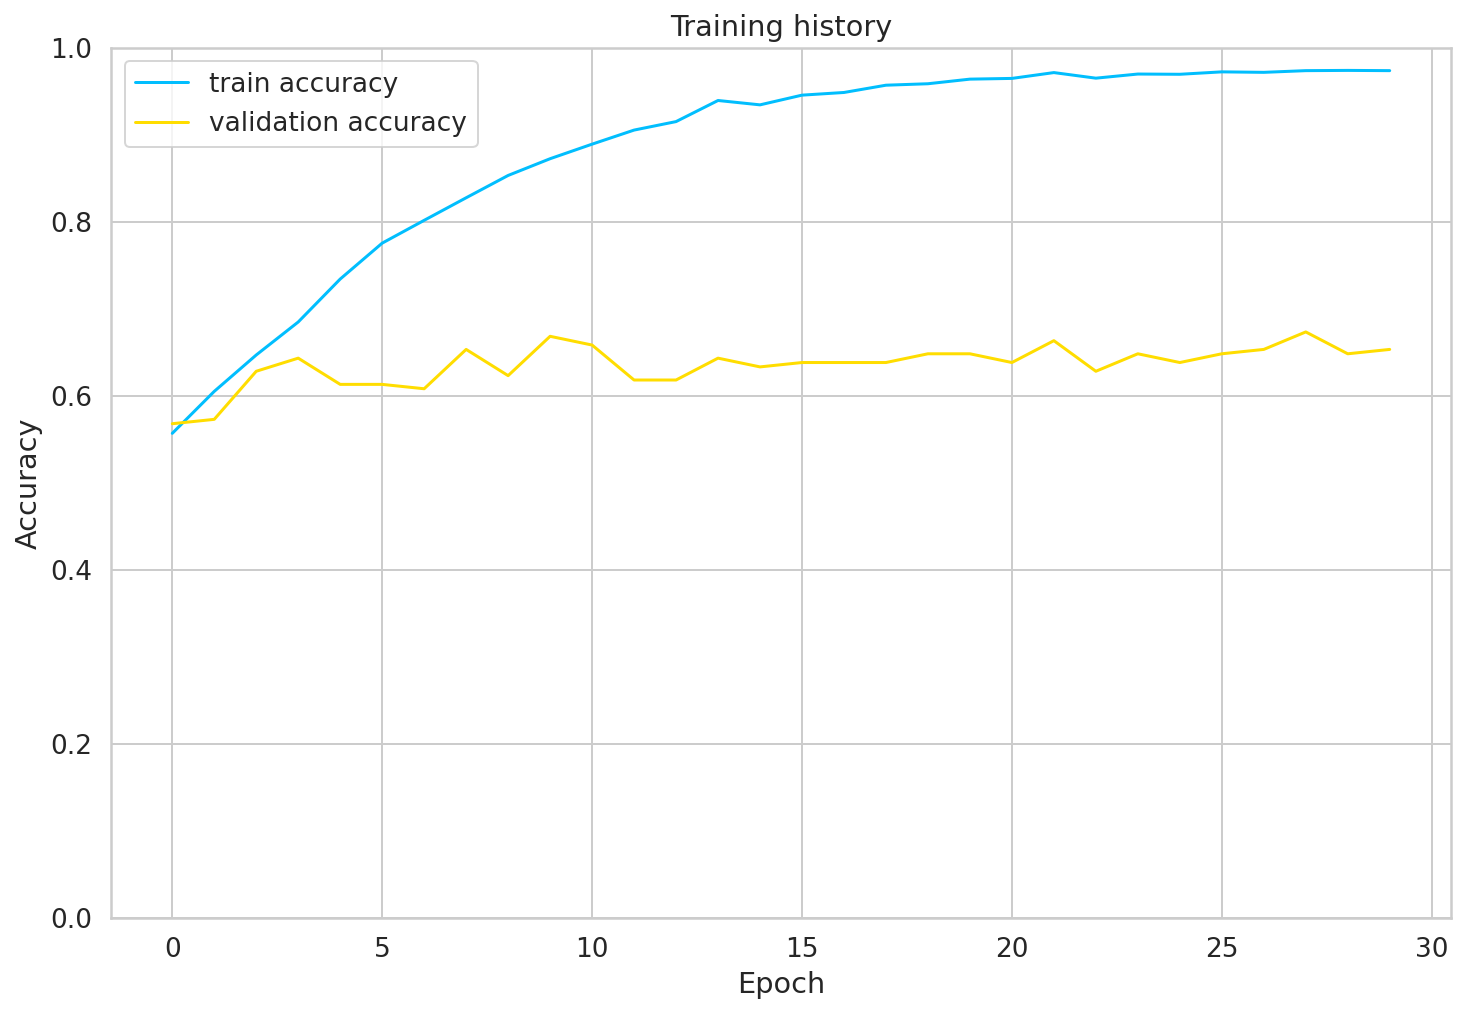

In [43]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

In [45]:
def get_predictions(model, data_loader):
  model = model.eval()
  aggr_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["comment_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      aggr_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return aggr_texts, predictions, prediction_probs, real_values

In [46]:
y_comment_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [47]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         NAG       0.80      0.79      0.80       578
         OAG       0.44      0.48      0.46       211
         CAG       0.64      0.60      0.62       208

    accuracy                           0.69       997
   macro avg       0.63      0.62      0.63       997
weighted avg       0.69      0.69      0.69       997



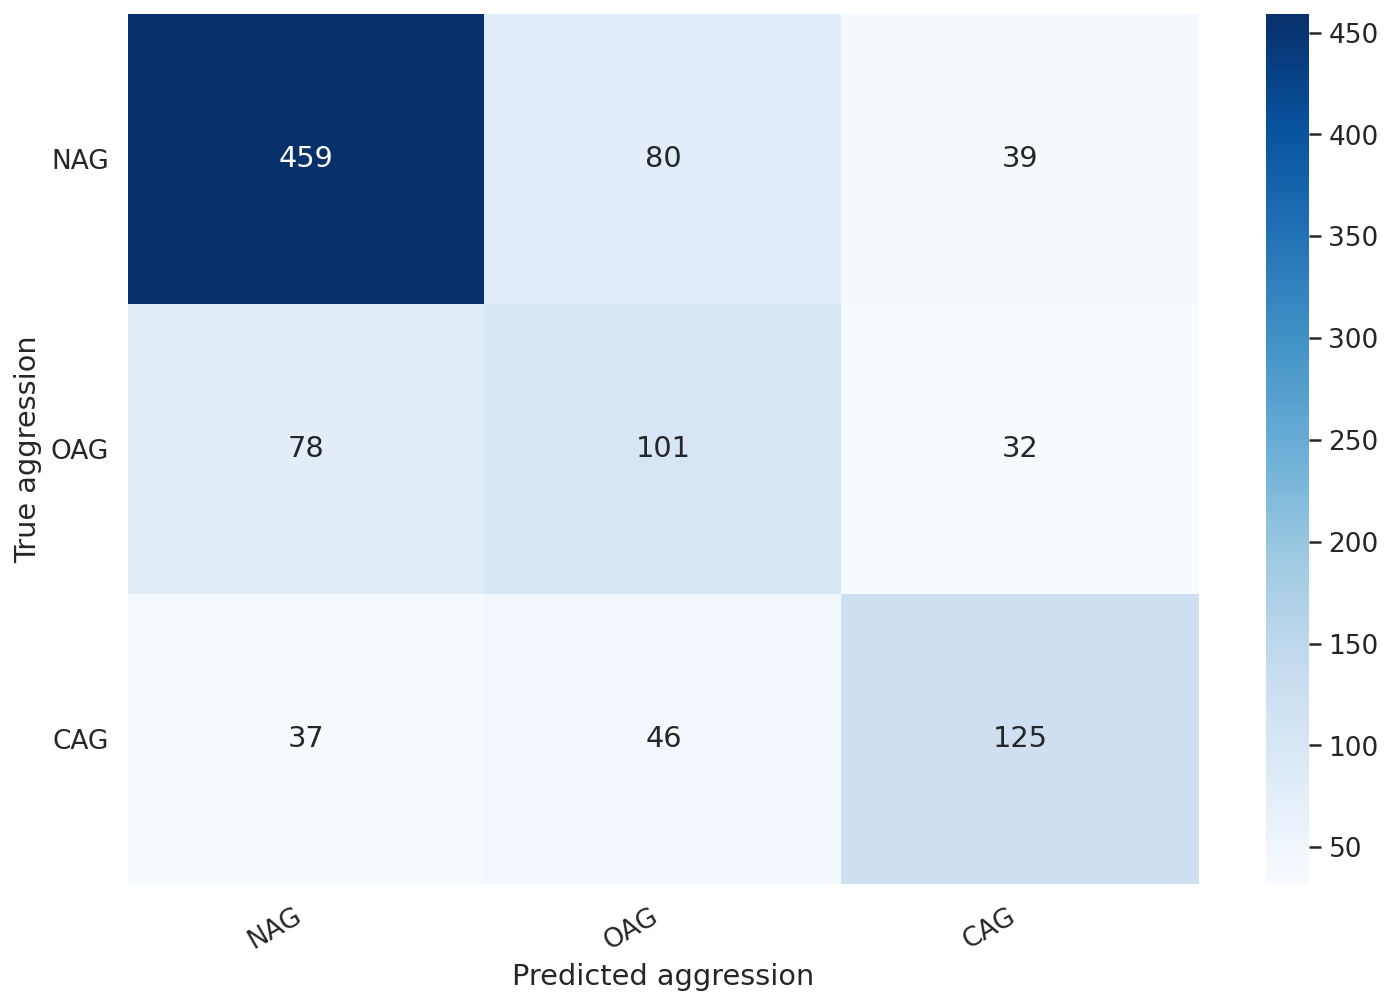

In [48]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True aggression')
  plt.xlabel('Predicted aggression');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [49]:
idx = 2
comment_text = y_comment_texts[idx]
true_aggression = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [50]:
print("\n".join(wrap(comment_text)))
print()
print(f'True aggression: {class_names[true_aggression]}')

Maine itni kam dislike kbhi nhii dekhi

True aggression: NAG


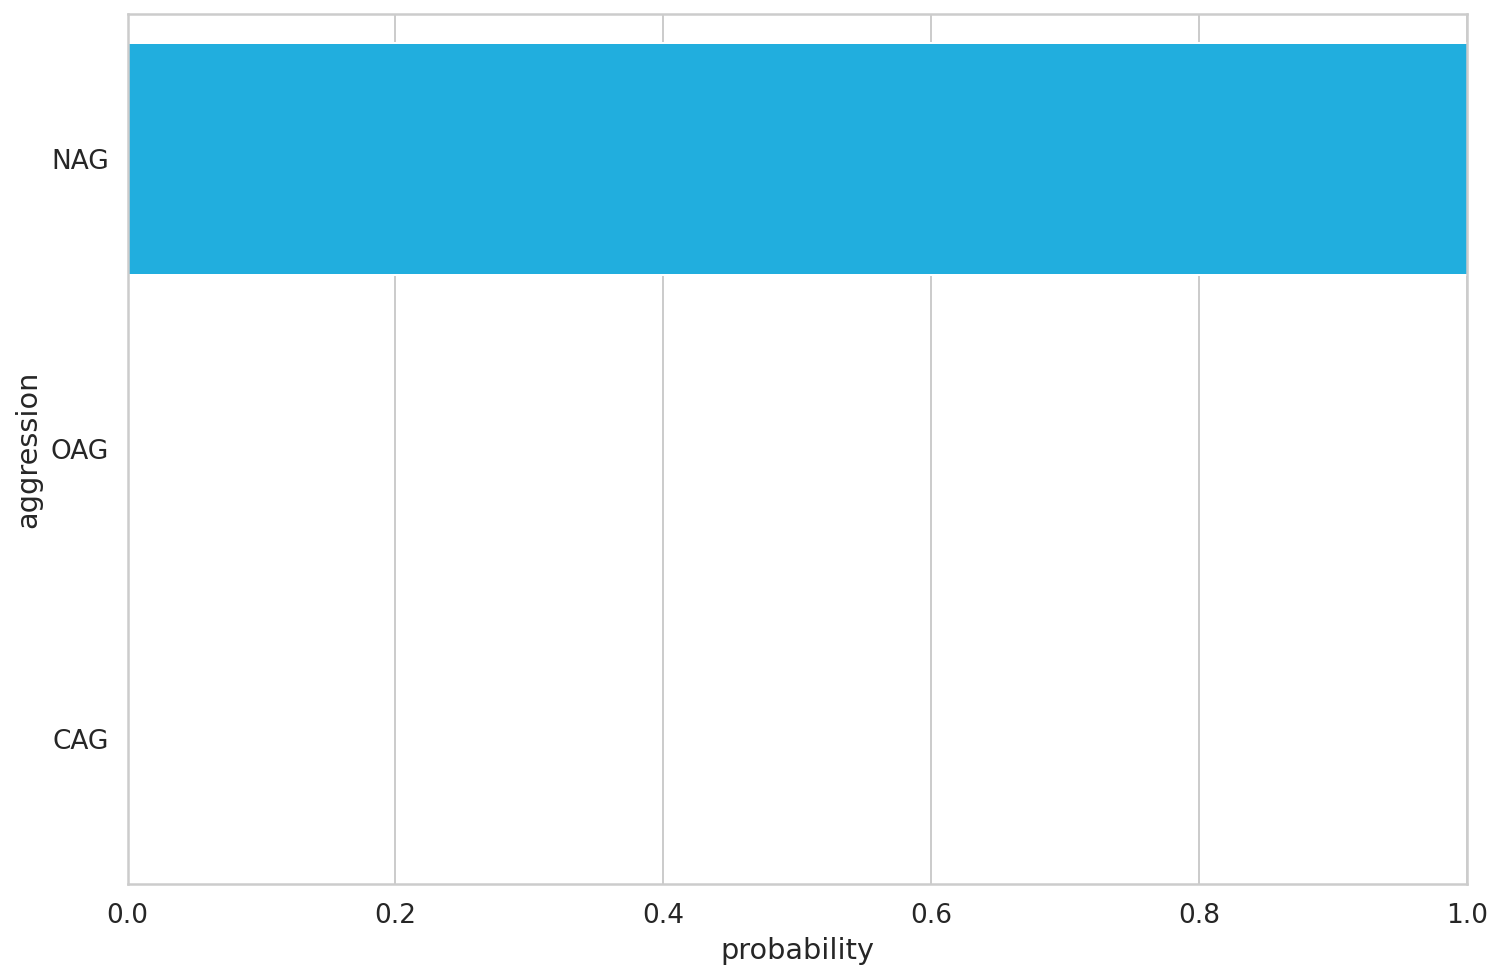

In [51]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('aggression')
plt.xlabel('probability')
plt.xlim([0, 1]);